In [ ]:
!pip install textattack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.7 MB/s eta 0:00:00
  Using cached n

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [ ]:
file_path = '/content/drive/MyDrive/Bachelor/Mental Health Dataset.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

posts predicted  intensity
0  I know as parent of child with down syndrome t...  negative         -1
1  but in my heart I know this is the future prom...   neutral          0
2  I have mylefibrosis which turn to leukemia the...  negative         -1
3  from one of my health group subject wayne dyer...   neutral          0
4  gmos now link to leukemia http nsnbc I 2013 07...   neutral          0

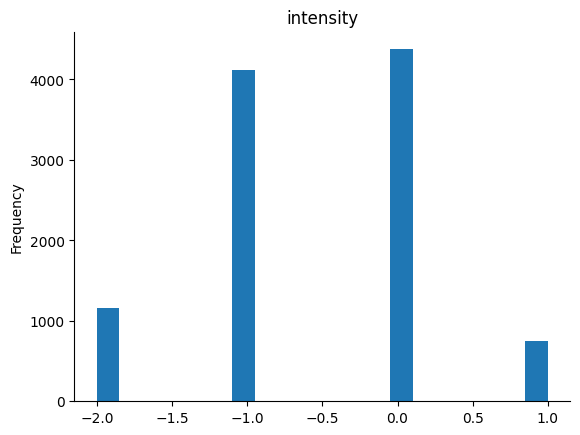

In [ ]:
# @title intensity

from matplotlib import pyplot as plt
df['intensity'].plot(kind='hist', bins=20, title='intensity')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10392 entries, 0 to 10391
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posts      10391 non-null  object
 1   predicted  10392 non-null  object
 2   intensity  10392 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ KB


In [ ]:
df_cleaned = df.dropna()

In [ ]:
df_cleaned['intensity'] += 2

<ipython-input-9-1be172418a3c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['intensity'] += 2


In [ ]:
df_cleaned = df_cleaned.drop(columns=['predicted'])

In [ ]:
import nltk

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

df_cleaned['posts'] = df_cleaned['posts'].apply(lambda x: x.lower())
df_cleaned['posts'] = df_cleaned['posts'].apply(word_tokenize)

In [ ]:
df_cleaned.head()

posts  intensity
0  [i, know, as, parent, of, child, with, down, s...          1
1  [but, in, my, heart, i, know, this, is, the, f...          2
2  [i, have, mylefibrosis, which, turn, to, leuke...          1
3  [from, one, of, my, health, group, subject, wa...          2
4  [gmos, now, link, to, leukemia, http, nsnbc, i...          2

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [token for token in text if token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

def lemmatize_dataset(dataset, text_column):
    dataset[text_column] = dataset[text_column].apply(lemmatize_text)
    return dataset

lemmatized_dataset = lemmatize_dataset(df_cleaned, 'posts')

In [ ]:
lemmatized_dataset.head()

posts  intensity
0  [know, parent, child, syndrome, hear, child, h...          1
1  [heart, know, future, promise, article, regard...          2
2  [mylefibrosis, turn, leukemia, want, stem, cel...          1
3  [one, health, group, subject, wayne, dyer, leu...          2
4  [gmos, link, leukemia, http, nsnbc, 2013, 07, ...          2

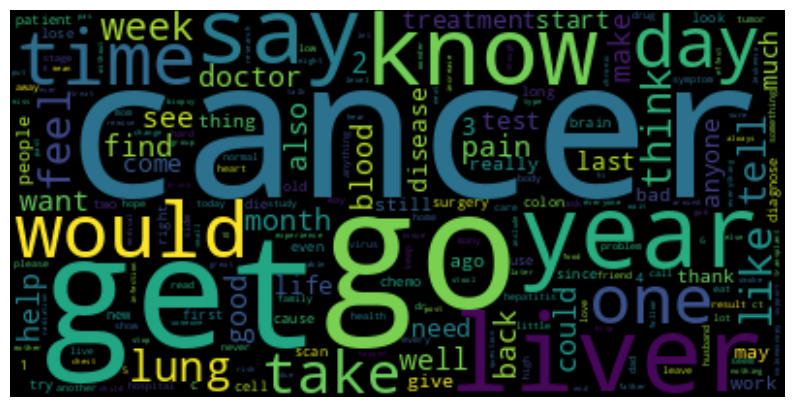

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq = {}
for text in lemmatized_dataset['posts']:
    for word in text:
        word_freq[word] = word_freq.get(word, 0) + 1

wordcloud = WordCloud().generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(lemmatized_dataset['posts'].values,
                                                    lemmatized_dataset['intensity'].values,
                                                    test_size=0.3,
                                                    stratify=lemmatized_dataset['intensity'].values)

In [ ]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 808, 1: 2878, 2: 3062, 3: 525}

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 347, 1: 1234, 2: 1312, 3: 225}

In [ ]:
X_train_lstm = X_train.copy()
X_test_lstm = X_test.copy()
X_train = [' '.join(doc) for doc in X_train]
X_test = [' '.join(doc) for doc in X_test]

In [ ]:
print(X_train_lstm)

[list(['ap', 'new', 'york', 'dana', 'reeve', 'spend', 'nine', 'year', 'care', 'paralyzed', 'husband', 'christopher', 'reeve', 'death', 'last', 'year', 'announce', 'tuesday', 'lung', 'cancer', 'reeve', '44', 'say', 'decide', 'disclose', 'illness', 'follow', 'rumor', 'health', 'medium', 'recently', 'diagnose', 'lung', 'cancer', 'currently', 'undergo', 'treatment', 'reeve', 'say', 'statement', 'excellent', 'team', 'physician', 'optimistic', 'prognosis', 'ever', 'feel', 'chris', 'face', 'challenge', 'say', 'always', 'look', 'ultimate', 'example', 'defy', 'odd', 'strength', 'courage', 'hope', 'face', 'lifea', 'adversitie', 'reeve', 'star', 'supermana', 'film', 'paralyze', 'horse', 'ride', 'accident', '1995', 'die', 'oct', '10', '2004'])
 list(['hello', 'want', 'talk', 'problem', 'know', 'call', 'realize', 'first', 'start', 'realize', 'time', 'suffer', 'anxiety', 'depression', 'since', 'around', '4', '5', 'old', 'brother', '10', 'year', 'old', 'use', 'treat', 'swear', 'like', 'trash', 'first

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print(X_train.shape, X_test.shape)

(7273, 1000) (3118, 1000)


In [ ]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
unique, counts = np.unique(y_train_smote, return_counts=True)
dict(zip(unique, counts))

{0: 3062, 1: 3062, 2: 3062, 3: 3062}

In [ ]:
under_sample = RandomUnderSampler()
x_under, y_under = under_sample.fit_resample(X_train, y_train)

In [ ]:
unique, counts = np.unique(y_under, return_counts=True)
dict(zip(unique, counts))

{0: 525, 1: 525, 2: 525, 3: 525}

In [ ]:
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X_train, y_train)

In [ ]:
unique, counts = np.unique(y_nm, return_counts=True)
dict(zip(unique, counts))

{0: 525, 1: 525, 2: 525, 3: 525}

In [ ]:
from sklearn.model_selection import GridSearchCV


def fine_tune(classificator, grid, X, y):
    grid_search = GridSearchCV(classificator, grid, cv=2, scoring='accuracy', verbose=3)
    grid_search.fit(X, y)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    return grid_search

In [ ]:
from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'alpha': list(map(lambda x: x/100, range(1, 50))),
    'fit_prior': [True, False],
    'force_alpha': [True, False],
}

grid_search = fine_tune(MultinomialNB(), param_grid, X_train, y_train)

Fitting 2 folds for each of 196 candidates, totalling 392 fits
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.676 total time=   0.1s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.659 total time=   0.0s
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.676 total time=   0.1s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.659 total time=   0.1s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.633 total time=   0.1s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.610 total time=   0.1s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.633 total time=   0.1s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.610 total time=   0.0s
[CV 1/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.676 total time=   0.0s
[CV 2/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.659 total time=   0.0s
[CV 1/2] END alpha=

Accuracy: 0.6751122514432328
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       347
           1       0.60      0.82      0.69      1234
           2       0.81      0.66      0.73      1312
           3       0.53      0.08      0.14       225

    accuracy                           0.68      3118
   macro avg       0.64      0.54      0.54      3118
weighted avg       0.69      0.68      0.66      3118



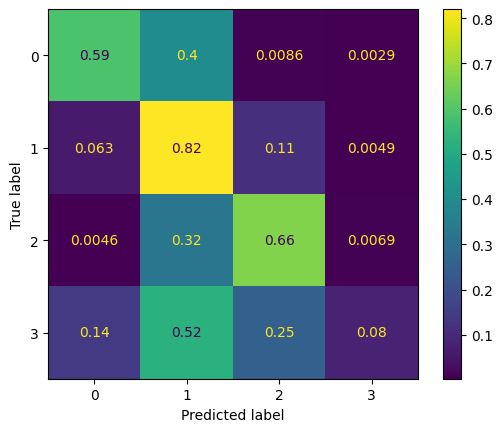

In [ ]:
params = {'alpha': 0.01, 'fit_prior': True, 'force_alpha': True}
clf = MultinomialNB(**params)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predicted)}")
print(classification_report(y_test, predicted))

matrix = confusion_matrix(y_test, predicted, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
grid_search = fine_tune(MultinomialNB(), param_grid, X_train_smote, y_train_smote)

Fitting 2 folds for each of 196 candidates, totalling 392 fits
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.696 total time=   0.1s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.699 total time=   0.1s
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.696 total time=   0.1s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.699 total time=   0.1s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.696 total time=   0.1s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.699 total time=   0.1s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.696 total time=   0.2s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.699 total time=   0.1s
[CV 1/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.695 total time=   0.1s
[CV 2/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.699 total time=   0.1s
[CV 1/2] END alpha=

Accuracy: 0.6330981398332264
              precision    recall  f1-score   support

           0       0.51      0.84      0.64       347
           1       0.65      0.64      0.64      1234
           2       0.86      0.59      0.70      1312
           3       0.28      0.53      0.37       225

    accuracy                           0.63      3118
   macro avg       0.57      0.65      0.59      3118
weighted avg       0.69      0.63      0.65      3118



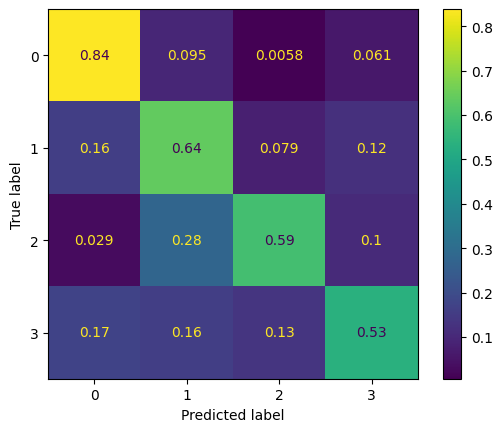

In [ ]:
params = {'alpha': 0.01, 'fit_prior': True, 'force_alpha': True}
clf_smote = MultinomialNB(**params)
clf_smote.fit(X_train_smote, y_train_smote)

predicted_smote = clf_smote.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predicted_smote)}")
print(classification_report(y_test, predicted_smote))

matrix_smote = confusion_matrix(y_test, predicted_smote, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_smote, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
grid_search = fine_tune(MultinomialNB(), param_grid, x_under, y_under)

Fitting 2 folds for each of 196 candidates, totalling 392 fits
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.620 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.624 total time=   0.0s
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.620 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.624 total time=   0.0s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.620 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.624 total time=   0.0s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.620 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.624 total time=   0.0s
[CV 1/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.627 total time=   0.0s
[CV 2/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.623 total time=   0.0s
[CV 1/2] END alpha=

Accuracy: 0.6071199486850545
              precision    recall  f1-score   support

           0       0.48      0.89      0.62       347
           1       0.62      0.61      0.62      1234
           2       0.86      0.54      0.67      1312
           3       0.27      0.52      0.35       225

    accuracy                           0.61      3118
   macro avg       0.56      0.64      0.56      3118
weighted avg       0.68      0.61      0.62      3118



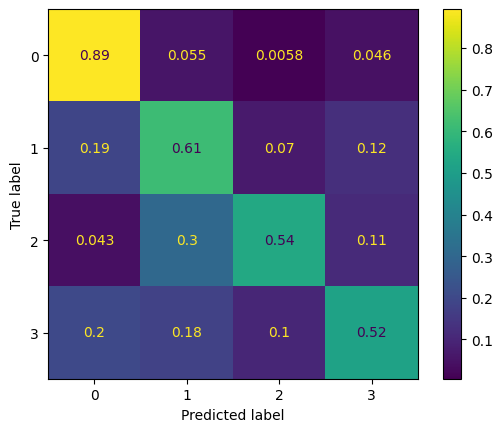

In [ ]:
params = {'alpha': 0.38, 'fit_prior': True, 'force_alpha': True}
clf_rus = MultinomialNB(**params)
clf_rus.fit(x_under, y_under)

predicted_under = clf_rus.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predicted_under)}")
print(classification_report(y_test, predicted_under))

matrix_under = confusion_matrix(y_test, predicted_under, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_under, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
grid_search = fine_tune(MultinomialNB(), param_grid, X_nm, y_nm)

Fitting 2 folds for each of 196 candidates, totalling 392 fits
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.636 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=True;, score=0.610 total time=   0.0s
[CV 1/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.636 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=True, force_alpha=False;, score=0.610 total time=   0.0s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.636 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=True;, score=0.609 total time=   0.0s
[CV 1/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.636 total time=   0.0s
[CV 2/2] END alpha=0.01, fit_prior=False, force_alpha=False;, score=0.609 total time=   0.0s
[CV 1/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.639 total time=   0.0s
[CV 2/2] END alpha=0.02, fit_prior=True, force_alpha=True;, score=0.609 total time=   0.0s
[CV 1/2] END alpha=

Accuracy: 0.5894804361770366
              precision    recall  f1-score   support

           0       0.49      0.88      0.63       347
           1       0.60      0.64      0.62      1234
           2       0.87      0.48      0.62      1312
           3       0.25      0.51      0.34       225

    accuracy                           0.59      3118
   macro avg       0.55      0.63      0.55      3118
weighted avg       0.68      0.59      0.60      3118



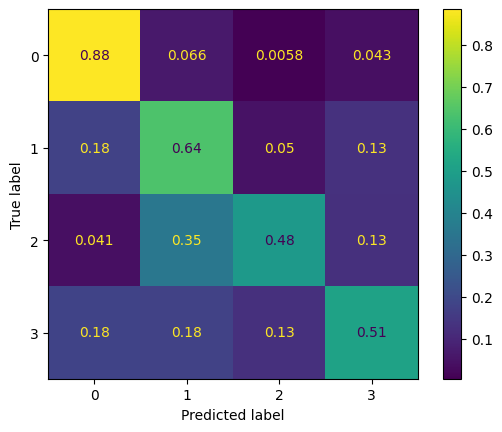

In [ ]:
params = {'alpha': 0.18, 'fit_prior': True, 'force_alpha': True}
clf_nearmiss = MultinomialNB(**params)
clf_nearmiss.fit(X_nm, y_nm)

predicted_nearmiss = clf_nearmiss.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predicted_nearmiss)}")
print(classification_report(y_test, predicted_nearmiss))

matrix_nm = confusion_matrix(y_test, predicted_nearmiss, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_nm, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'dual': [True, False],
    'tol': list(map(lambda x: 10**(-x), range(2, 6))),
    'C': list(map(lambda x: x/10, range(1, 11))),
    'fit_intercept': [True, False],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}

fine_tune(LogisticRegression(), param_grid, X_train, y_train)

Fitting 2 folds for each of 2880 candidates, totalling 5760 fits
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.599 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.603 total time=   1.6s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.657 total time=   0.2s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.664 total time=   0.3s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.657 total time=   0.3s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.664 total time=   0.2s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.657 total time=   0.2s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.664 total time=   0.1s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.657 total time=   0.3s
[CV 2/2] END C=0.1, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.657 total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.664 total time=   1.3s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.653 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.642 total time=   1.1s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.681 total time=   0.1s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.687 total time=   0.2s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.681 total time=   0.1s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.687 total time=   0.2s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.681 total time=   0.1s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.687 total time=   0.2s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.681 total time=   0.2s
[CV 2/2] END C=0.2, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.681 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.687 total time=   0.7s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.676 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.664 total time=   2.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.692 total time=   0.3s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.701 total time=   0.3s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.692 total time=   0.3s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.701 total time=   0.3s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.692 total time=   0.3s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.701 total time=   0.3s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.692 total time=   0.2s
[CV 2/2] END C=0.3, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.692 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.702 total time=   0.7s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.687 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.675 total time=   1.8s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.696 total time=   0.4s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.707 total time=   0.3s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.4s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.707 total time=   0.3s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.696 total time=   0.4s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.707 total time=   0.4s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.696 total time=   0.4s
[CV 2/2] END C=0.4, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.696 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.707 total time=   0.7s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.690 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.684 total time=   1.5s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.713 total time=   0.3s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.713 total time=   0.3s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.713 total time=   0.3s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.5, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.698 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.713 total time=   1.3s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.695 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.689 total time=   1.5s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.714 total time=   0.2s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.714 total time=   0.2s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.714 total time=   0.2s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.6, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.699 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.715 total time=   0.9s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.697 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.694 total time=   1.7s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.697 total time=   0.3s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.714 total time=   0.8s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.697 total time=   0.3s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.714 total time=   0.3s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.697 total time=   0.3s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.714 total time=   0.3s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.697 total time=   0.3s
[CV 2/2] END C=0.7, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.697 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.715 total time=   0.8s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.698 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.699 total time=   1.5s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.718 total time=   0.3s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.718 total time=   0.3s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.718 total time=   0.3s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.699 total time=   0.3s
[CV 2/2] END C=0.8, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.700 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.718 total time=   1.3s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=0.0001;, score=0.680 total time=   1.8s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.682 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.680 total time=   1.8s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.700 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.700 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.700 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.8, dual=

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.703 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.699 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.703 total time=   2.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.701 total time=   0.5s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.718 total time=   0.5s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.701 total time=   0.5s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.718 total time=   0.5s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.701 total time=   0.5s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.718 total time=   0.5s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.701 total time=   0.4s
[CV 2/2] END C=0.9, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.701 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.718 total time=   0.8s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.682 total time=   2.4s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.702 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.702 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.702 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.699 total time=   0.1s
[CV 2/2] END C=0.9, dual=

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.701 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.705 total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.701 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.705 total time=   1.9s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.703 total time=   0.3s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.720 total time=   0.3s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.703 total time=   0.3s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.720 total time=   0.3s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.703 total time=   0.3s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.720 total time=   0.3s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.703 total time=   0.3s
[CV 2/2] END C=1.0, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.703 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.720 total time=   0.8s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.684 total time=   1.8s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.698 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.703 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.698 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.703 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.698 total time=   0.2s
[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.703 total time=   0.2s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.698 total time=   0.2s
[CV 2/2] END C=1.0, dual=

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4320 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

Best Parameters: {'C': 1.0, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Best Score: 0.7115369462434282


GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0],
                         'dual': [True, False], 'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=3)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7331622835150737
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       347
           1       0.69      0.77      0.73      1234
           2       0.79      0.82      0.81      1312
           3       0.55      0.20      0.29       225

    accuracy                           0.73      3118
   macro avg       0.68      0.60      0.62      3118
weighted avg       0.73      0.73      0.72      3118



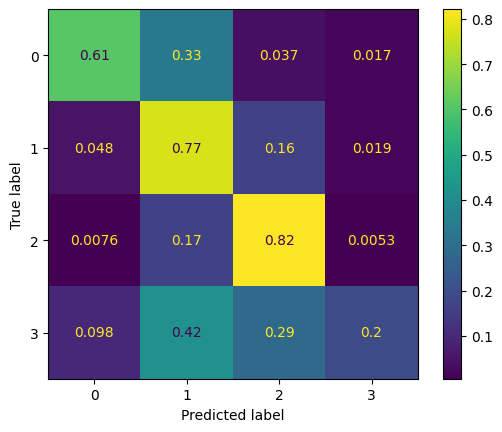

In [ ]:
params = {'C': 1.0, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}
lr_clf = LogisticRegression(**params)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

matrix_lr_clf = confusion_matrix(y_test, y_pred, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_lr_clf, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(LogisticRegression(), param_grid, X_train_smote, y_train_smote)

Fitting 2 folds for each of 2880 candidates, totalling 5760 fits
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.683 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.704 total time=   3.7s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.730 total time=   0.6s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.774 total time=   0.3s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.730 total time=   0.4s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.774 total time=   0.3s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.730 total time=   0.4s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.774 total time=   0.3s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.730 total time=   0.4s
[CV 2/2] END C=0.2, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.730 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.774 total time=   1.6s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.699 total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.724 total time=   2.6s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.739 total time=   0.4s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.781 total time=   0.4s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.739 total time=   0.4s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.781 total time=   0.4s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.739 total time=   0.4s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.781 total time=   0.4s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.739 total time=   0.4s
[CV 2/2] END C=0.3, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.739 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.781 total time=   1.5s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.712 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.739 total time=   2.9s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.745 total time=   0.5s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.787 total time=   0.5s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.745 total time=   0.6s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.787 total time=   0.7s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.745 total time=   0.8s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.787 total time=   0.7s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.745 total time=   0.8s
[CV 2/2] END C=0.4, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.746 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.787 total time=   2.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.722 total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.753 total time=   3.2s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.750 total time=   0.5s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.792 total time=   0.5s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.750 total time=   0.6s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.792 total time=   0.4s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.750 total time=   0.5s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.792 total time=   0.5s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.750 total time=   0.9s
[CV 2/2] END C=0.5, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.750 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.792 total time=   1.5s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.725 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.762 total time=   3.5s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.751 total time=   1.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.793 total time=   0.9s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.751 total time=   1.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.793 total time=   0.9s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.751 total time=   0.7s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.793 total time=   0.5s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.751 total time=   0.7s
[CV 2/2] END C=0.6, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.752 total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.793 total time=   1.6s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.767 total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.729 total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.767 total time=   4.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.754 total time=   1.1s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.796 total time=   0.9s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.754 total time=   1.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.796 total time=   0.5s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.754 total time=   0.7s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.796 total time=   0.5s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.754 total time=   0.7s
[CV 2/2] END C=0.7, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.755 total time=   1.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.796 total time=   1.5s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.719 total time=   4.2s
[CV 2/2] END C=0.7, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.742 total time=   3.5s
[CV 1/2] END C=0.7, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.747 total time=   0.3s
[CV 2/2] END C=0.7, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.770 total time=   0.2s
[CV 1/2] END C=0.7, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.747 total time=   0.3s
[CV 2/2] END C=0.7, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.770 total time=   0.4s
[CV 1/2] END C=0.7, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.747 total time=   0.4s
[CV 2/2] END C=0.7, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.770 total time=   0.4s
[CV 1/2] END C=0.7, dual=F

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.774 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.733 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.774 total time=   3.9s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.758 total time=   0.7s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.799 total time=   0.6s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.758 total time=   0.9s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.799 total time=   0.9s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.758 total time=   1.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.799 total time=   0.9s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.758 total time=   0.9s
[CV 2/2] END C=0.8, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.758 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.799 total time=   1.6s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.723 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.750 total time=   4.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.749 total time=   0.3s
[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.771 total time=   0.3s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.749 total time=   0.5s
[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.771 total time=   0.4s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.749 total time=   0.5s
[CV 2/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.771 total time=   0.4s
[CV 1/2] END C=0.8, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.749 total time=   0.5s
[CV 2/2] END C=0.8, dual=

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.782 total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.738 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.782 total time=   4.7s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.758 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.798 total time=   1.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.758 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.798 total time=   0.6s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.758 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.798 total time=   0.6s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.758 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.798 total time=   0.6s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.01;, score=0.752 total time=   0.2s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.01;, score=0.788 total time=   0.2s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.001;, score=0.752 total time=   0.2s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.001;, score=0.788 total time=   0.2s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.0001;, score=0.752 total time=   0.2s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.0001;, score=0.788 total time=   0.2s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=1e-05;, score=0.752 total time=   0.3s
[CV 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.757 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.798 total time=   1.5s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.757 total time=   5.4s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.750 total time=   0.2s
[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.772 total time=   0.2s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.750 total time=   0.3s
[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.772 total time=   0.3s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.750 total time=   0.3s
[CV 2/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.772 total time=   0.3s
[CV 1/2] END C=0.9, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.750 total time=   0.3s
[CV 2/2] END C=0.9, dual=

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.785 total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.741 total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.785 total time=   4.4s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.758 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.798 total time=   0.6s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.758 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.798 total time=   0.6s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.758 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.798 total time=   0.8s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.758 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.798 total time=   1.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.01;, score=0.752 total time=   0.3s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.01;, score=0.789 total time=   0.2s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.001;, score=0.752 total time=   0.3s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.001;, score=0.790 total time=   0.3s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.0001;, score=0.752 total time=   0.4s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=0.0001;, score=0.789 total time=   0.3s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=liblinear, tol=1e-05;, score=0.752 total time=   0.3s
[CV 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.758 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.798 total time=   1.8s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l1, solver=saga, tol=1e-05;, score=0.762 total time=   4.7s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.751 total time=   0.4s
[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.01;, score=0.773 total time=   0.3s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.751 total time=   0.4s
[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.001;, score=0.773 total time=   0.4s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.751 total time=   0.4s
[CV 2/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.773 total time=   0.4s
[CV 1/2] END C=1.0, dual=False, fit_intercept=False, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.751 total time=   0.4s
[CV 2/2] END C=1.0, dual=

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4320 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

Best Parameters: {'C': 1.0, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}
Best Score: 0.7793109079033311


GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0],
                         'dual': [True, False], 'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=3)

0.6927517639512508
              precision    recall  f1-score   support

           0       0.63      0.78      0.70       347
           1       0.73      0.66      0.70      1234
           2       0.82      0.72      0.77      1312
           3       0.29      0.54      0.38       225

    accuracy                           0.69      3118
   macro avg       0.62      0.68      0.64      3118
weighted avg       0.73      0.69      0.70      3118



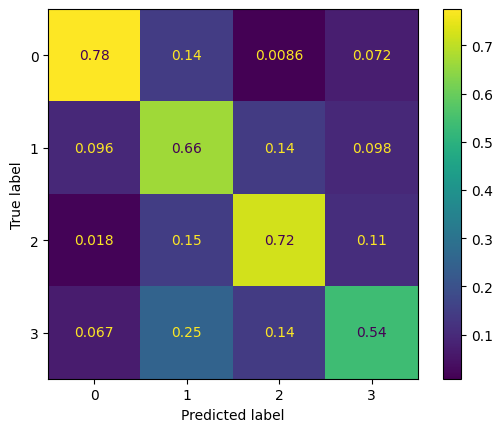

In [ ]:
params = {'C': 1.0, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.01}
lr_clf_res = LogisticRegression(**params)
lr_clf_res.fit(X_train_smote, y_train_smote)

y_pred_res = lr_clf_res.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_res)}")
print(classification_report(y_test, y_pred_res))

matrix_lr_clf_res = confusion_matrix(y_test, y_pred_res, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_lr_clf_res, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(LogisticRegression(), param_grid, x_under, y_under)

Fitting 2 folds for each of 2880 candidates, totalling 5760 fits
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.340 total time=   0.3s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.338 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.340 total time=   0.3s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.338 total time=   0.1s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.642 total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.652 total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.642 total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.651 total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.642 total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.651 total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.644 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.651 total time=   0.2s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.466 total time=   0.3s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.488 total time=   0.2s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.651 total time=   0.1s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.657 total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.651 total time=   0.1s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.657 total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.651 total time=   0.1s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.657 total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.650 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.659 total time=   0.2s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.554 total time=   0.5s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.556 total time=   0.3s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.663 total time=   0.1s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.663 total time=   0.1s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.663 total time=   0.1s
[CV 1/2] END C=0.3, dual=False, fi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.655 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.664 total time=   0.2s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.578 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.579 total time=   0.3s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.660 total time=   0.1s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.671 total time=   0.1s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.660 total time=   0.1s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.671 total time=   0.1s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.660 total time=   0.4s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.671 total time=   0.1s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.660 total time=   0.1s
[CV 2/2] END C=0.4, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.657 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.669 total time=   0.4s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.581 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.599 total time=   0.3s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.671 total time=   0.1s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.671 total time=   0.1s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.671 total time=   0.1s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.5, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.655 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.671 total time=   0.2s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.602 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.605 total time=   0.6s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.672 total time=   0.1s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.672 total time=   0.1s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.672 total time=   0.1s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.658 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.670 total time=   0.2s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.621 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.610 total time=   0.5s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.666 total time=   0.1s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.666 total time=   0.1s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.666 total time=   0.1s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.658 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.658 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.666 total time=   0.2s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.627 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.621 total time=   0.4s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.665 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.665 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.665 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.659 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.665 total time=   0.2s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.631 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.640 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.630 total time=   0.4s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.663 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.667 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.663 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.667 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.663 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.667 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.663 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.664 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.668 total time=   0.2s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=0.0001;, score=0.636 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.638 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.636 total time=   0.4s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.664 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.664 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.664 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.664 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.664 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.664 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.664 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.663 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.665 total time=   0.2s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4320 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0],
                         'dual': [True, False], 'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=3)

0.6619627966645285
              precision    recall  f1-score   support

           0       0.57      0.83      0.67       347
           1       0.70      0.57      0.63      1234
           2       0.81      0.71      0.76      1312
           3       0.30      0.62      0.41       225

    accuracy                           0.66      3118
   macro avg       0.60      0.68      0.62      3118
weighted avg       0.70      0.66      0.67      3118



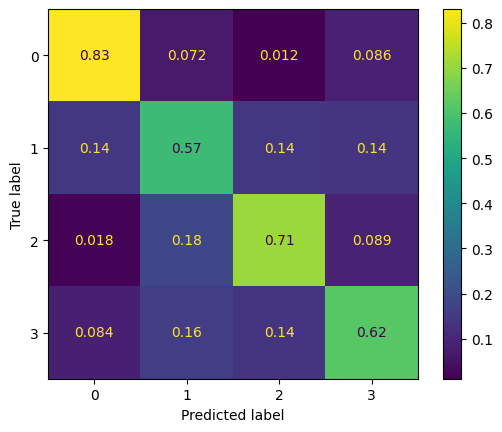

In [ ]:
params = {'C': 0.7, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.01}
lr_clf_under = LogisticRegression(**params)
lr_clf_under.fit(x_under, y_under)

y_pred_under = lr_clf_under.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_under)}")
print(classification_report(y_test, y_pred_under))

matrix_lr_clf_under = confusion_matrix(y_test, y_pred_under, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_lr_clf_under, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(LogisticRegression(), param_grid, X_nm, y_nm)

Fitting 2 folds for each of 2880 candidates, totalling 5760 fits
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=True, fit_intercept=True, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.369 total time=   0.3s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.354 total time=   0.1s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.654 total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.651 total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.654 total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.651 total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.654 total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.651 total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.655 total time=   0.4s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.651 total time=   0.4s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.1, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.516 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.458 total time=   0.3s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.662 total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.655 total time=   0.1s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.662 total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.655 total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.662 total time=   0.1s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.655 total time=   0.1s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.662 total time=   0.0s
[CV 2/2] END C=0.2, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.662 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.655 total time=   0.3s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.2, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.550 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.532 total time=   0.6s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.657 total time=   0.1s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.657 total time=   0.1s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.657 total time=   0.1s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.659 total time=   0.1s
[CV 2/2] END C=0.3, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.659 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.656 total time=   0.3s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.3, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.573 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.564 total time=   0.3s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.655 total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.656 total time=   0.1s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.656 total time=   0.1s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.656 total time=   0.1s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.4, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.655 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.658 total time=   0.4s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.4, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.577 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.589 total time=   0.4s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.651 total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.659 total time=   0.1s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.651 total time=   0.1s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.659 total time=   0.1s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.651 total time=   0.1s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.659 total time=   0.1s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.651 total time=   0.1s
[CV 2/2] END C=0.5, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.650 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.659 total time=   0.3s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.5, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.591 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.596 total time=   0.4s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.662 total time=   0.1s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.662 total time=   0.1s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.662 total time=   0.1s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.655 total time=   0.1s
[CV 2/2] END C=0.6, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.655 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.662 total time=   0.3s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.6, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.616 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.598 total time=   0.4s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.667 total time=   0.1s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.667 total time=   0.1s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.667 total time=   0.1s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.7, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.653 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.668 total time=   0.3s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.7, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.630 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.606 total time=   0.4s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.656 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.668 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.656 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.668 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.656 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.668 total time=   0.1s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.656 total time=   0.1s
[CV 2/2] END C=0.8, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.656 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.667 total time=   0.5s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.8, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.633 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.603 total time=   0.4s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.668 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.668 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.668 total time=   0.1s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.653 total time=   0.1s
[CV 2/2] END C=0.9, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.653 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.667 total time=   0.4s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=0.9, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.633 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l1, solver=saga, tol=1e-05;, score=0.611 total time=   0.4s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.653 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.01;, score=0.669 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.653 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.001;, score=0.669 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.653 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.669 total time=   0.1s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=lbfgs, tol=1e-05;, score=0.653 total time=   0.1s
[CV 2/2] END C=1.0, dual=False, f

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.651 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=l2, solver=saga, tol=1e-05;, score=0.668 total time=   0.3s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=1.0, dual=False, fit_intercept=True, penalty=elasticnet, solver=lbfgs, tol=1e-05;, score=nan total time

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4320 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0],
                         'dual': [True, False], 'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=3)

0.654265554842848
              precision    recall  f1-score   support

           0       0.57      0.82      0.67       347
           1       0.70      0.60      0.65      1234
           2       0.81      0.66      0.73      1312
           3       0.30      0.62      0.40       225

    accuracy                           0.65      3118
   macro avg       0.59      0.68      0.61      3118
weighted avg       0.70      0.65      0.67      3118



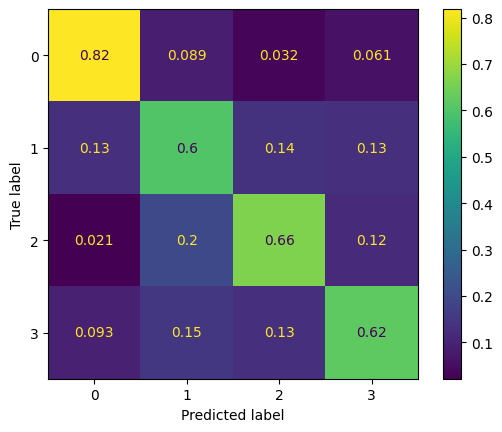

In [ ]:
params = {}
lr_clf_nm = LogisticRegression(**params)
lr_clf_nm.fit(X_nm, y_nm)

y_pred_nm = lr_clf_nm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_nm)}")
print(classification_report(y_test, y_pred_nm))

matrix_lr_clf_nm = confusion_matrix(y_test, y_pred_nm, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_lr_clf_nm, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


fine_tune(RandomForestClassifier(), param_grid, X_train, y_train)

Fitting 2 folds for each of 432 candidates, totalling 864 fits
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.673 total time=   2.8s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.668 total time=   2.5s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.670 total time=   4.2s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.667 total time=   4.1s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.677 total time=   9.4s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.672 total time=   9.4s
[CV 1/2] 

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

Accuracy: 0.6953175112251443
              precision    recall  f1-score   support

           0       0.75      0.35      0.48       347
           1       0.61      0.84      0.71      1234
           2       0.80      0.76      0.78      1312
           3       0.65      0.07      0.12       225

    accuracy                           0.70      3118
   macro avg       0.70      0.50      0.52      3118
weighted avg       0.71      0.70      0.67      3118



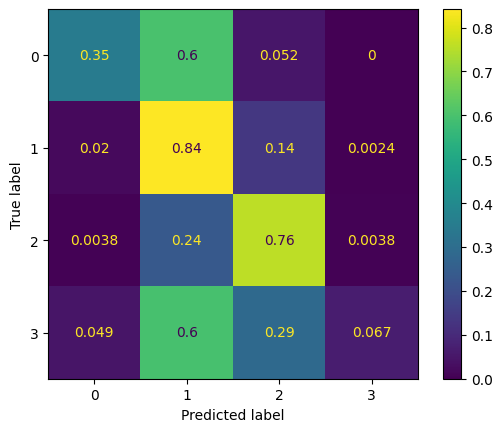

In [ ]:
params = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

matrix_rf = confusion_matrix(y_test, y_pred_rf, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_rf, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(RandomForestClassifier(), param_grid, X_train_smote, y_train_smote)

Fitting 2 folds for each of 432 candidates, totalling 864 fits
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.785 total time=   9.0s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.827 total time=   9.8s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.807 total time=  11.7s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.834 total time=  11.5s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.805 total time=  22.3s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.837 total time=  22.8s
[CV 1/2] 

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

Accuracy: 0.691468890314304
              precision    recall  f1-score   support

           0       0.61      0.55      0.58       347
           1       0.63      0.79      0.70      1234
           2       0.79      0.74      0.77      1312
           3       0.54      0.09      0.15       225

    accuracy                           0.69      3118
   macro avg       0.64      0.54      0.55      3118
weighted avg       0.69      0.69      0.68      3118



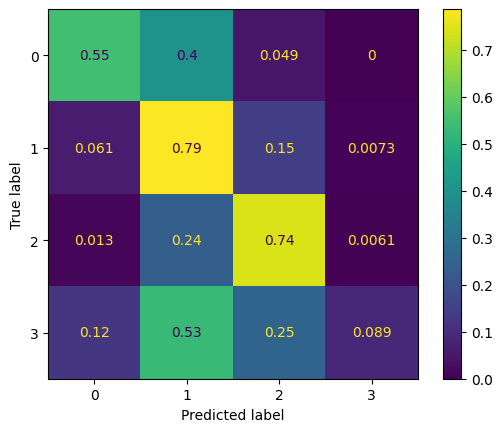

In [ ]:
params = {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

rf_model_res = RandomForestClassifier(**params)
rf_model_res.fit(X_train_smote, y_train_smote)

y_pred_rf_res = rf_model_res.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_res)}")
print(classification_report(y_test, y_pred_rf_res))

matrix_rf_res = confusion_matrix(y_test, y_pred_rf_res, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_rf_res, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(RandomForestClassifier(), param_grid, x_under, y_under)

Fitting 2 folds for each of 432 candidates, totalling 864 fits
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.608 total time=   1.4s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.611 total time=   1.4s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.621 total time=   3.0s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.639 total time=   2.8s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.630 total time=   6.4s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.654 total time=   3.5s
[CV 1/2] 

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

Accuracy: 0.6478511866581141
              precision    recall  f1-score   support

           0       0.48      0.90      0.63       347
           1       0.67      0.56      0.61      1234
           2       0.82      0.70      0.75      1312
           3       0.33      0.48      0.39       225

    accuracy                           0.65      3118
   macro avg       0.57      0.66      0.60      3118
weighted avg       0.69      0.65      0.66      3118



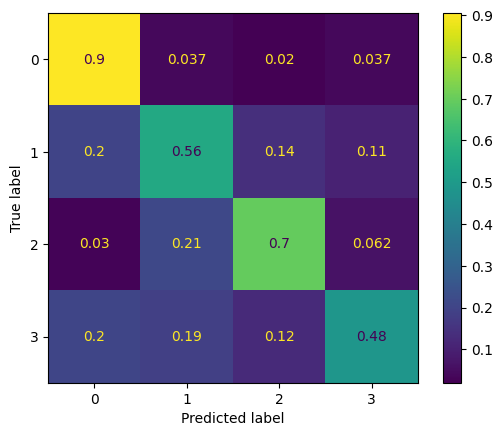

In [ ]:
params = {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

rf_model_under = RandomForestClassifier(**params)
rf_model_under.fit(x_under, y_under)

y_pred_rf_under = rf_model_under.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_under)}")
print(classification_report(y_test, y_pred_rf_under))

matrix_rf_under = confusion_matrix(y_test, y_pred_rf_under, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_rf_under, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(RandomForestClassifier(), param_grid, X_nm, y_nm)

Fitting 2 folds for each of 432 candidates, totalling 864 fits
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.610 total time=   0.7s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.590 total time=   1.5s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.619 total time=   1.4s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.609 total time=   1.5s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.632 total time=   2.7s
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.633 total time=   3.5s
[CV 1/2] 

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

Accuracy: 0.6334188582424631
              precision    recall  f1-score   support

           0       0.46      0.90      0.61       347
           1       0.67      0.58      0.62      1234
           2       0.85      0.65      0.73      1312
           3       0.27      0.47      0.34       225

    accuracy                           0.63      3118
   macro avg       0.56      0.65      0.58      3118
weighted avg       0.70      0.63      0.65      3118



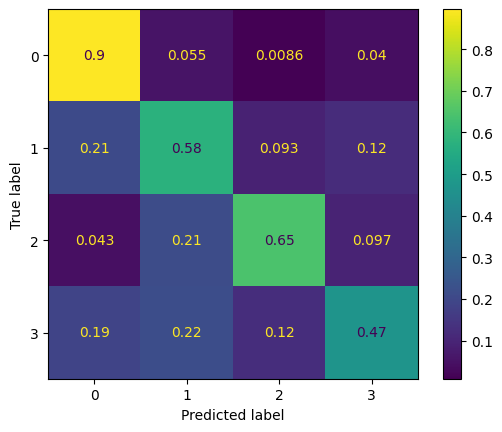

In [ ]:
params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

rf_model_nm = RandomForestClassifier(**params)
rf_model_nm.fit(X_nm, y_nm)

y_pred_rf_nm = rf_model_nm.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_nm)}")
print(classification_report(y_test, y_pred_rf_nm))

matrix_rf_nm = confusion_matrix(y_test, y_pred_rf_nm, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_rf_nm, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

fine_tune(SVC(), param_grid, X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.654 total time=  14.9s
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.658 total time=  14.8s
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.636 total time=  18.9s
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.635 total time=  19.3s
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.654 total time=  14.9s
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.658 total time=  15.0s
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.421 total time=  18.2s
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.421 total time=  19.4s
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.654 total time=  14.9s
[CV 2/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.658 total time=  14.9s
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=rbf;,

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

Accuracy: 0.7344451571520205
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       347
           1       0.70      0.75      0.73      1234
           2       0.79      0.82      0.81      1312
           3       0.56      0.27      0.37       225

    accuracy                           0.73      3118
   macro avg       0.69      0.62      0.64      3118
weighted avg       0.73      0.73      0.73      3118



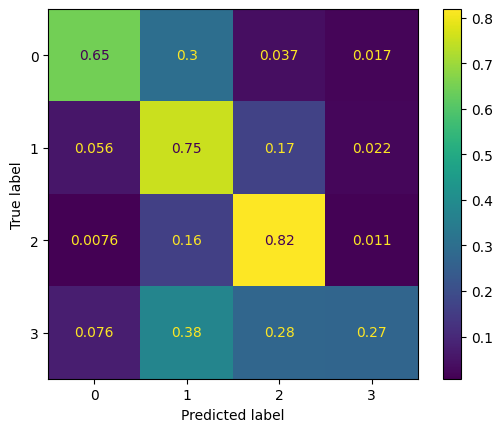

In [ ]:
params = {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

svm_model = SVC(**params)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))

matrix_svc = confusion_matrix(y_test, y_pred_svm, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_svc, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(SVC(), param_grid, X_train_smote, y_train_smote)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.726 total time= 1.3min
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.762 total time=  53.8s
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.667 total time= 1.1min
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.812 total time= 1.2min
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.726 total time=  55.2s
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.762 total time=  53.4s
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.648 total time= 1.5min
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.691 total time= 1.3min
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.726 total time=  55.4s
[CV 2/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.762 total time=  53.2s
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=rbf;,

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

Accuracy: 0.737010904425914
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       347
           1       0.70      0.76      0.73      1234
           2       0.79      0.82      0.81      1312
           3       0.55      0.25      0.35       225

    accuracy                           0.74      3118
   macro avg       0.69      0.62      0.64      3118
weighted avg       0.73      0.74      0.73      3118



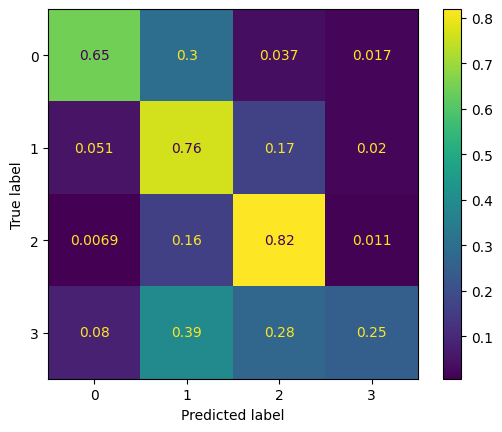

In [ ]:
params = {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

svm_model_res = SVC(**params)
svm_model_res.fit(X_train_smote, y_train_smote)

y_pred_svm_res = svm_model_res.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_res)}")
print(classification_report(y_test, y_pred_svm_res))

matrix_svc = confusion_matrix(y_test, y_pred_svm_res, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_svc, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(SVC(), param_grid, x_under, y_under)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.630 total time=   1.6s
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.661 total time=   1.6s
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.386 total time=   1.7s
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.438 total time=   1.7s
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.630 total time=   1.7s
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.661 total time=   1.9s
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.377 total time=   2.8s
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.461 total time=   1.7s
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.630 total time=   1.5s
[CV 2/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.661 total time=   1.6s
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=rbf;,

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

Accuracy: 0.6683771648492624
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       347
           1       0.70      0.60      0.64      1234
           2       0.82      0.71      0.76      1312
           3       0.31      0.59      0.40       225

    accuracy                           0.67      3118
   macro avg       0.60      0.68      0.62      3118
weighted avg       0.71      0.67      0.68      3118



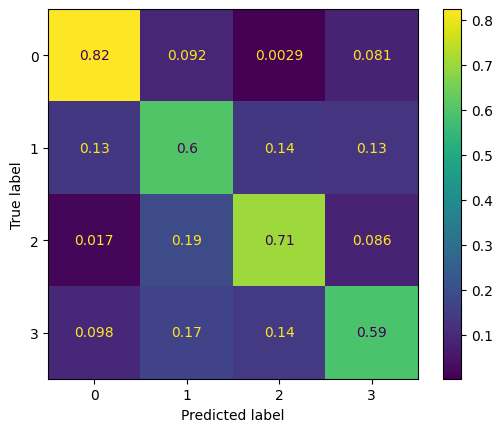

In [ ]:
params = {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

svm_model_under = SVC(**params)
svm_model_under.fit(x_under, y_under)

y_pred_svm_under = svm_model_under.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_under)}")
print(classification_report(y_test, y_pred_svm_under))

matrix_svc = confusion_matrix(y_test, y_pred_svm_under, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_svc, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(SVC(), param_grid, X_nm, y_nm)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.664 total time=   2.2s
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.619 total time=   3.0s
[CV 1/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.385 total time=   2.5s
[CV 2/2] END C=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.374 total time=   5.1s
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.664 total time=   4.3s
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=linear;, score=0.619 total time=   3.0s
[CV 1/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.376 total time=   3.1s
[CV 2/2] END C=0.1, degree=2, gamma=auto, kernel=rbf;, score=0.417 total time=   3.6s
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.664 total time=   3.3s
[CV 2/2] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.619 total time=   2.2s
[CV 1/2] END C=0.1, degree=3, gamma=scale, kernel=rbf;,

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=3)

Accuracy: 0.6475304682488775
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       347
           1       0.70      0.60      0.65      1234
           2       0.80      0.65      0.72      1312
           3       0.27      0.60      0.37       225

    accuracy                           0.65      3118
   macro avg       0.59      0.67      0.60      3118
weighted avg       0.70      0.65      0.66      3118



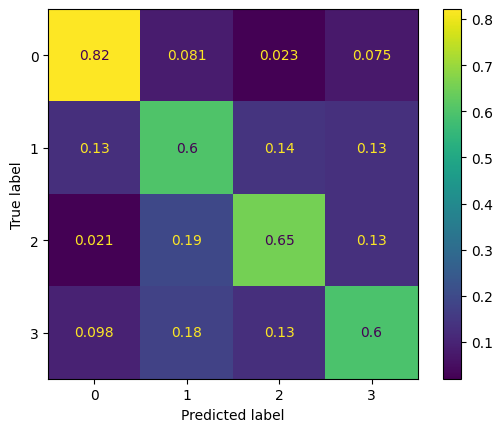

In [ ]:
params = {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

svm_model_nm = SVC(**params)
svm_model_nm.fit(X_nm, y_nm)

y_pred_svm_nm = svm_model_nm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_nm)}")
print(classification_report(y_test, y_pred_svm_nm))

matrix_svc = confusion_matrix(y_test, y_pred_svm_nm, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_svc, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

fine_tune(GradientBoostingClassifier(), param_grid, X_train, y_train)

Accuracy: 0.7155227710070559
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       347
           1       0.67      0.76      0.71      1234
           2       0.77      0.80      0.79      1312
           3       0.53      0.18      0.27       225

    accuracy                           0.72      3118
   macro avg       0.67      0.58      0.60      3118
weighted avg       0.71      0.72      0.70      3118



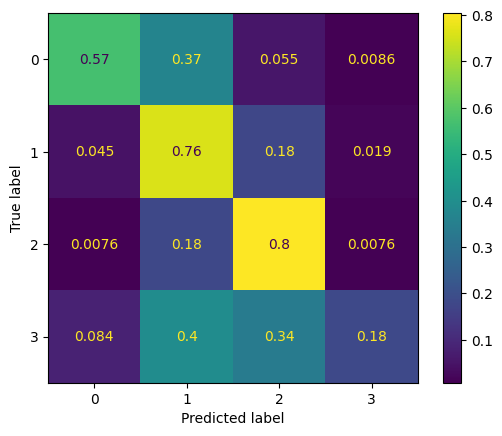

In [ ]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

gb_model = GradientBoostingClassifier(**params)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))

matrix_gb = confusion_matrix(y_test, y_pred_gb, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_gb, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(GradientBoostingClassifier(), param_grid, X_train_smote, y_train_smote)

Fitting 2 folds for each of 486 candidates, totalling 972 fits
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.642 total time=   3.4s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.716 total time=   3.4s
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.652 total time=   7.5s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.727 total time=   6.3s
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.670 total time=  13.0s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.751 total time=  11.1s
[CV

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

Accuracy: 0.7036561898652983
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       347
           1       0.68      0.73      0.71      1234
           2       0.79      0.75      0.77      1312
           3       0.39      0.35      0.37       225

    accuracy                           0.70      3118
   macro avg       0.63      0.62      0.62      3118
weighted avg       0.70      0.70      0.70      3118



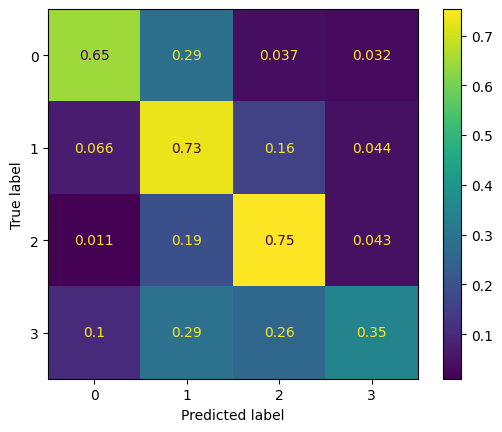

In [ ]:
params = {'learning_rate': 0.3, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
gb_model_res = GradientBoostingClassifier(**params)
gb_model_res.fit(X_train_smote, y_train_smote)

y_pred_gb_res = gb_model_res.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_res)}")
print(classification_report(y_test, y_pred_gb_res))

matrix_gb = confusion_matrix(y_test, y_pred_gb_res, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_gb, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(GradientBoostingClassifier(), param_grid, x_under, y_under)

Fitting 2 folds for each of 486 candidates, totalling 972 fits
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.635 total time=   1.0s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.626 total time=   1.7s
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.627 total time=   4.1s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.632 total time=   1.9s
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.643 total time=   4.2s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.635 total time=   2.2s
[CV

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

Accuracy: 0.6443232841565106
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       347
           1       0.72      0.54      0.62      1234
           2       0.78      0.70      0.74      1312
           3       0.30      0.60      0.40       225

    accuracy                           0.64      3118
   macro avg       0.58      0.67      0.60      3118
weighted avg       0.69      0.64      0.65      3118



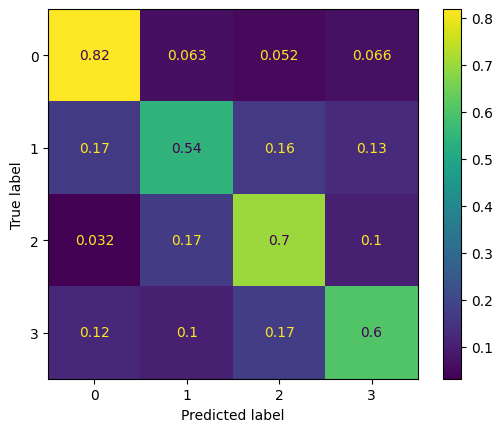

In [ ]:
params = {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

gb_model_under = GradientBoostingClassifier(**params)
gb_model_under.fit(x_under, y_under)

y_pred_gb_under = gb_model_under.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_under)}")
print(classification_report(y_test, y_pred_gb_under))

matrix_gb = confusion_matrix(y_test, y_pred_gb_under, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_gb, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
fine_tune(GradientBoostingClassifier(), param_grid, X_nm, y_nm)

Fitting 2 folds for each of 486 candidates, totalling 972 fits
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.605 total time=   0.9s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.600 total time=   1.0s
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.603 total time=   1.8s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.612 total time=   1.2s
[CV 1/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.621 total time=   2.3s
[CV 2/2] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.632 total time=   2.4s
[CV

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

Accuracy: 0.6177036561898653
              precision    recall  f1-score   support

           0       0.46      0.80      0.58       347
           1       0.69      0.55      0.61      1234
           2       0.80      0.64      0.71      1312
           3       0.27      0.58      0.36       225

    accuracy                           0.62      3118
   macro avg       0.56      0.64      0.57      3118
weighted avg       0.68      0.62      0.63      3118



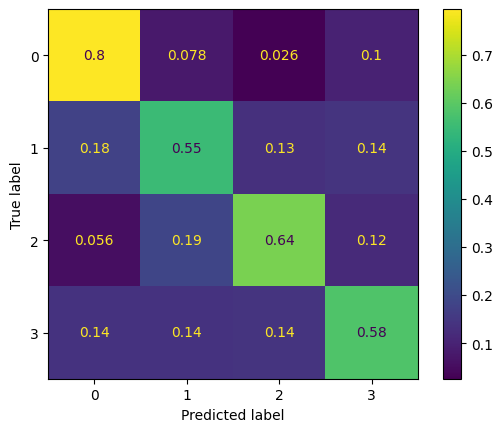

In [ ]:
params = {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

gb_model_nm = GradientBoostingClassifier(**params)
gb_model_nm.fit(X_nm, y_nm)

y_pred_gb_nm = gb_model_nm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_nm)}")
print(classification_report(y_test, y_pred_gb_nm))

matrix_gb = confusion_matrix(y_test, y_pred_gb_nm, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_gb, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

#LSTM

text preprocessing

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size:", vocab_size)
print("X_train shape:", X_train_padded.shape)
print("X_test shape:", X_test_padded.shape)

Vocabulary size: 31460
X_train shape: (7273, 100)
X_test shape: (3118, 100)


In [ ]:
num_classes = 4

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train_padded, y_train_one_hot, batch_size=64, epochs=3, validation_data=(X_test_padded, y_test_one_hot))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 50)           1573000   
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1602700 (6.11 MB)
Trainable params: 1602700 (6.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
114/114 [==============================] - 37s 237ms/step - loss: 1.0494 - accuracy: 0.5313 - val_loss: 0.8252 - val_accuracy: 0.6671
Epoch 2/3
114/114 [==============================] - 25s 216ms/step - loss: 0.6932 - accuracy: 0.7198 - val_loss: 0.7402 - val_accu

98/98 [==============================] - 2s 19ms/step
Accuracy: 0.7023733162283515
              precision    recall  f1-score   support

           0       0.64      0.49      0.56       347
           1       0.66      0.78      0.71      1234
           2       0.79      0.77      0.78      1312
           3       0.44      0.22      0.29       225

    accuracy                           0.70      3118
   macro avg       0.63      0.56      0.59      3118
weighted avg       0.70      0.70      0.69      3118



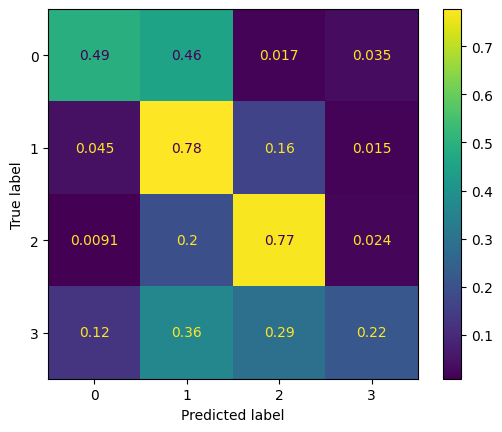

In [ ]:
y_pred_nn = model.predict(X_test_padded)
y_pred_nn = list(map(lambda x: np.argmax(x), y_pred_nn))

print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(classification_report(y_test, y_pred_nn))

matrix_nn = confusion_matrix(y_test, y_pred_nn, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_nn, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

# LSTM Oversampling

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

smote = SMOTE()
X_train_smote_lstm, y_train_smote_lstm = smote.fit_resample(X_train_padded, y_train)

vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size:", vocab_size)
print("X_train shape:", X_train_padded.shape)
print("X_test shape:", X_test_padded.shape)

Vocabulary size: 31460
X_train shape: (7273, 100)
X_test shape: (3118, 100)


In [ ]:
num_classes = 4
y_train_one_hot = to_categorical(y_train_smote_lstm, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
embedding_dim = 50

model_smote = Sequential()
model_smote.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_smote.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model_smote.add(Dense(units=4, activation='softmax'))

model_smote.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_smote.summary())

model_smote.fit(X_train_smote_lstm, y_train_one_hot, batch_size=64, epochs=3, validation_data=(X_test_padded, y_test_one_hot))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 50)           1573000   
                                                                 
 lstm_7 (LSTM)               (None, 128)               91648     
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1665164 (6.35 MB)
Trainable params: 1665164 (6.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
192/192 [==============================] - 78s 344ms/step - loss: 1.1368 - accuracy: 0.4772 - val_loss: 1.0374 - val_accuracy: 0.5683
Epoch 2/3
192/192 [==============================] - 67s 350ms/step - loss: 0.8482 - accuracy: 0.6381 - val_loss: 0.8389 - val_accu

98/98 [==============================] - 4s 33ms/step
Accuracy: 0.6420782552918538
              precision    recall  f1-score   support

           0       0.41      0.59      0.49       347
           1       0.67      0.63      0.65      1234
           2       0.79      0.73      0.76      1312
           3       0.25      0.25      0.25       225

    accuracy                           0.64      3118
   macro avg       0.53      0.55      0.54      3118
weighted avg       0.66      0.64      0.65      3118



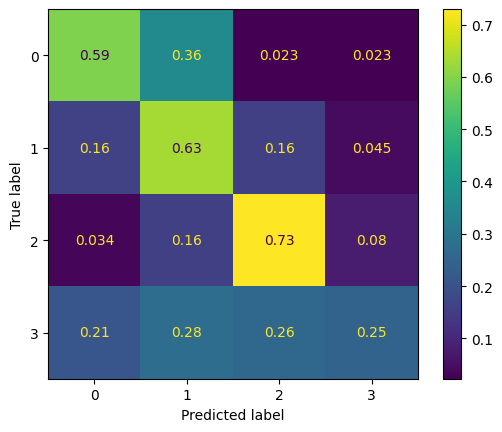

In [ ]:
y_pred_nn = model_smote.predict(X_test_padded)
y_pred_nn = list(map(lambda x: np.argmax(x), y_pred_nn))

print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(classification_report(y_test, y_pred_nn))

matrix_nn = confusion_matrix(y_test, y_pred_nn, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_nn, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

# LSTM Undersampling

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

under_sampler = RandomUnderSampler()
X_under_lstm, y_under_lstm = under_sampler.fit_resample(X_train_padded, y_train)

In [ ]:
num_classes = 4

y_train_one_hot = to_categorical(y_under_lstm, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
embedding_dim = 50
model_under = Sequential()
model_under.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_under.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model_under.add(Dense(units=4, activation='softmax'))

model_under.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_under.summary())

model_under.fit(X_under_lstm, y_train_one_hot, batch_size=64, epochs=3, validation_data=(X_test_padded, y_test_one_hot))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 50)           1573000   
                                                                 
 lstm_9 (LSTM)               (None, 128)               91648     
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1665164 (6.35 MB)
Trainable params: 1665164 (6.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
33/33 [==============================] - 24s 448ms/step - loss: 1.3601 - accuracy: 0.3424 - val_loss: 1.1926 - val_accuracy: 0.4657
Epoch 2/3
33/33 [==============================] - 17s 525ms/step - loss: 1.0950 - accuracy: 0.5129 - val_loss: 1.0596 - val_accurac

In [ ]:
y_pred_nn = model_under.predict(X_test_padded)

98/98 [==============================] - 4s 38ms/step


Accuracy: 0.5981398332264272
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       347
           1       0.60      0.50      0.55      1234
           2       0.72      0.71      0.72      1312
           3       0.22      0.46      0.30       225

    accuracy                           0.60      3118
   macro avg       0.55      0.57      0.55      3118
weighted avg       0.63      0.60      0.61      3118



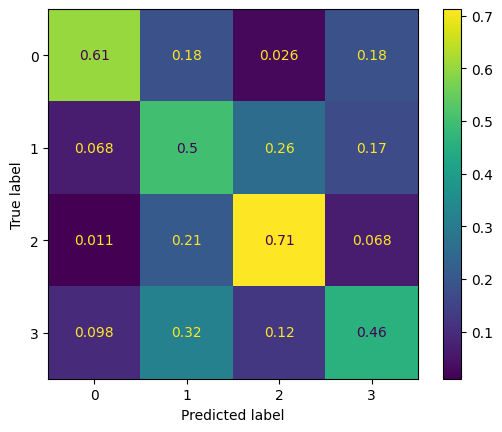

In [ ]:
y_pred_nn = list(map(lambda x: np.argmax(x), y_pred_nn))

print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(classification_report(y_test, y_pred_nn))

matrix_nn = confusion_matrix(y_test, y_pred_nn, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_nn, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

nm = NearMiss()
X_nm_lstm, y_nm_lstm = nm.fit_resample(X_train_padded, y_train)

num_classes = 4

y_train_one_hot = to_categorical(y_nm_lstm, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
embedding_dim = 50
model_nm = Sequential()
model_nm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_nm.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model_nm.add(Dense(units=4, activation='softmax'))

model_nm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_nm.summary())

model_nm.fit(X_nm_lstm, y_train_one_hot, batch_size=64, epochs=3, validation_data=(X_test_padded, y_test_one_hot))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 50)           1573000   
                                                                 
 lstm_4 (LSTM)               (None, 128)               91648     
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1665164 (6.35 MB)
Trainable params: 1665164 (6.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
33/33 [==============================] - 38s 955ms/step - loss: 1.2376 - accuracy: 0.4090 - val_loss: 2.1699 - val_accuracy: 0.2514
Epoch 2/3
33/33 [==============================] - 14s 417ms/step - loss: 1.0236 - accuracy: 0.5286 - val_loss: 1.8667 - val_accuracy

In [ ]:
y_pred_nn = model_nm.predict(X_test_padded)

98/98 [==============================] - 5s 50ms/step


Accuracy: 0.4416292495189224
              precision    recall  f1-score   support

           0       0.41      0.46      0.43       347
           1       0.47      0.71      0.57      1234
           2       0.83      0.21      0.33      1312
           3       0.13      0.32      0.19       225

    accuracy                           0.44      3118
   macro avg       0.46      0.42      0.38      3118
weighted avg       0.59      0.44      0.43      3118



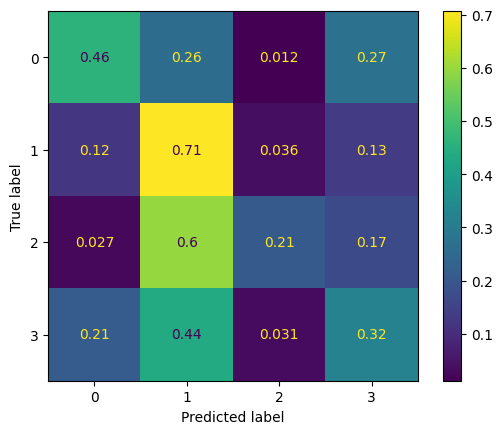

In [ ]:
y_pred_nn = list(map(lambda x: np.argmax(x), y_pred_nn))

print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(classification_report(y_test, y_pred_nn))

matrix_nn = confusion_matrix(y_test, y_pred_nn, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_nn, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

regularization and other stuff

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# x_rus, y_rus = rus.fit_resample(X_train_padded, y_train)

In [ ]:
y_train[y_train == 1] = 0
y_train[y_train == 3] = 2
y_train[y_train == 2] = 1

y_test[y_test == 1] = 0
y_test[y_test == 3] = 2
y_test[y_test == 2] = 1

In [ ]:
from keras.utils import to_categorical

num_classes = 2

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam

# Define LSTM model
embedding_dim = 50  # choose an appropriate dimension
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(weight_decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

# Train the model
model.fit(X_train_padded, y_train_one_hot, batch_size=8, epochs=10, validation_data=(X_test_padded, y_test_one_hot))

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 100, 50)           1667350   
                                                                 
 lstm_30 (LSTM)              (None, 64)                29440     
                                                                 
 dense_30 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1696920 (6.47 MB)
Trainable params: 1696920 (6.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
866/866 [==============================] - 129s 142ms/step - loss: 0.0102 - accuracy: 0.9991 - val_loss: 5.6937 - val_accuracy: 0.5372
Epoch 2/10
866/866 [==============================] - 119s 138ms/step - loss: 3.0179e-06 - accuracy: 1.0000 - val_loss: 6.1338 -

In [ ]:
y_pred_nn = model.predict(X_test_padded)
print(y_pred_nn)

109/109 [==============================] - 4s 29ms/step
[[0.01510344 0.9502436  0.01137333 0.02327959]
 [0.00571654 0.98922724 0.00334685 0.00170945]
 [0.00363013 0.00185348 0.941744   0.05277237]
 ...
 [0.00826627 0.00854309 0.9367087  0.04648193]
 [0.01561197 0.9684705  0.0127383  0.00317928]
 [0.00324649 0.9722987  0.02027542 0.00417942]]


In [ ]:
print(y_test_one_hot[100:110])
print(y_test[100:110])

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[3 2 1 1 2 2 1 1 2 2]


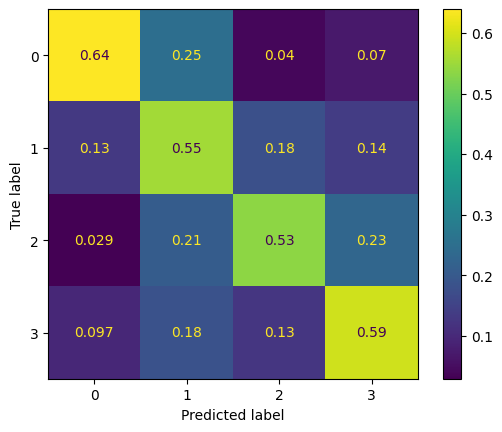

In [ ]:
y_pred_nn = list(map(lambda x: np.argmax(x), y_pred_nn))

matrix_nn = confusion_matrix(y_test, y_pred_nn, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_nn, display_labels=[0, 1, 2, 3])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.52      0.64      0.57       427
           1       0.65      0.55      0.60      1434
           2       0.70      0.53      0.61      1334
           3       0.23      0.59      0.33       269

    accuracy                           0.56      3464
   macro avg       0.52      0.58      0.53      3464
weighted avg       0.62      0.56      0.58      3464

